Projeto Final de Spark

Campanha Nacional de Vacinação contra Covid-19

Nível Básico:
Visualizações à partir dos dados: https://mobileapps.saude.gov.br/esus-vepi/files/unAFkcaNDeXajurGB7LChj8SgQYS2ptm/04bd3419b22b9cc5c6efac2c6528100d_HIST_PAINEL_COVIDBR_06jul2021.rar

1. Enviar os dados para o hdfs.

In [ ]:
!hdfs dfs -put /input/HIST_PAINEL_COVIDBR_06jul2021 /user/jes/data

In [1]:
!hdfs dfs -ls /user/jes/data/HIST_PAINEL_COVIDBR_06jul2021

Found 4 items
-rw-r--r--   3 root supergroup   62492959 2021-07-13 00:36 /user/jes/data/HIST_PAINEL_COVIDBR_06jul2021/HIST_PAINEL_COVIDBR_2020_Parte1_06jul2021.csv
-rw-r--r--   3 root supergroup   76520681 2021-07-13 00:36 /user/jes/data/HIST_PAINEL_COVIDBR_06jul2021/HIST_PAINEL_COVIDBR_2020_Parte2_06jul2021.csv
-rw-r--r--   3 root supergroup   91120916 2021-07-13 00:36 /user/jes/data/HIST_PAINEL_COVIDBR_06jul2021/HIST_PAINEL_COVIDBR_2021_Parte1_06jul2021.csv
-rw-r--r--   3 root supergroup    3046774 2021-07-13 00:36 /user/jes/data/HIST_PAINEL_COVIDBR_06jul2021/HIST_PAINEL_COVIDBR_2021_Parte2_06jul2021.csv


2. Otimizar todos os dados do hdfs para uma tabela Hive particionada por município.

In [4]:
import pyspark.sql.functions as F
from pyspark.sql.types import *
painel_covidDF = spark.read.option("inferSchema","true") \
                         .option("header","true") \
                         .options(delimiter=';') \
                         .csv("/user/jes/data/HIST_PAINEL_COVIDBR_06jul2021/HIST_PAINEL_COVIDBR_202*.csv")

In [7]:
painel_covidDF.printSchema()

root
 |-- regiao: string (nullable = true)
 |-- estado: string (nullable = true)
 |-- municipio: string (nullable = true)
 |-- coduf: integer (nullable = true)
 |-- codmun: integer (nullable = true)
 |-- codRegiaoSaude: integer (nullable = true)
 |-- nomeRegiaoSaude: string (nullable = true)
 |-- data: timestamp (nullable = true)
 |-- semanaEpi: integer (nullable = true)
 |-- populacaoTCU2019: integer (nullable = true)
 |-- casosAcumulado: decimal(10,0) (nullable = true)
 |-- casosNovos: integer (nullable = true)
 |-- obitosAcumulado: integer (nullable = true)
 |-- obitosNovos: integer (nullable = true)
 |-- Recuperadosnovos: integer (nullable = true)
 |-- emAcompanhamentoNovos: integer (nullable = true)
 |-- interior/metropolitana: integer (nullable = true)



In [6]:
painel_covid_hive_partitionDF = painel_covidDF.write.partitionBy("municipio").saveAsTable("painel_covid")

3. Criar as 3 vizualizações pelo Spark com os dados enviados para o HDFS:
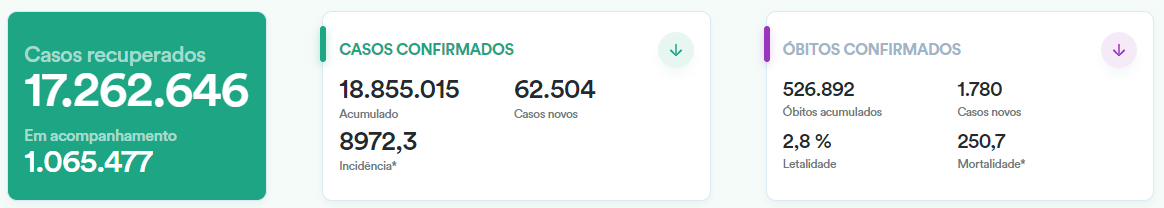

In [9]:
painel_covid_hdfsDF = spark.read.table("painel_covid")

In [10]:
painel_covid_hdfsDF.printSchema()

root
 |-- regiao: string (nullable = true)
 |-- estado: string (nullable = true)
 |-- coduf: integer (nullable = true)
 |-- codmun: integer (nullable = true)
 |-- codRegiaoSaude: integer (nullable = true)
 |-- nomeRegiaoSaude: string (nullable = true)
 |-- data: timestamp (nullable = true)
 |-- semanaEpi: integer (nullable = true)
 |-- populacaoTCU2019: integer (nullable = true)
 |-- casosAcumulado: decimal(10,0) (nullable = true)
 |-- casosNovos: integer (nullable = true)
 |-- obitosAcumulado: integer (nullable = true)
 |-- obitosNovos: integer (nullable = true)
 |-- Recuperadosnovos: integer (nullable = true)
 |-- emAcompanhamentoNovos: integer (nullable = true)
 |-- interior/metropolitana: integer (nullable = true)
 |-- municipio: string (nullable = true)



4. Salvar a primeira visualização como tabela Hive

In [27]:
covid_recup_acompDF = painel_covid_hdfsDF.select(F.col("Recuperadosnovos").alias("Casos_recuperados"), \
                                                 F.col("emAcompanhamentoNovos").alias("Em_acompanhamento")) \
                                         .where(F.col("regiao") == "Brasil") \
                                         .sort(F.desc("data")) \
                                         .limit(1)

In [25]:
covid_recup_acompDF.show(truncate=False)

+-----------------+-----------------+
|Casos recuperados|Em acompanhamento|
+-----------------+-----------------+
|17262646         |1065477          |
+-----------------+-----------------+



In [28]:
covid_recup_acompDF.write.saveAsTable("covid_recup_acomp")

5. Salvar a segunda visualização com formato parquet e compressão snappy

In [42]:
covid_casos_confirmDF = painel_covid_hdfsDF.select(F.col("casosAcumulado"), \
                                                   F.col("casosNovos"), \
                                                   F.format_number(((F.col("casosAcumulado") * F.lit(100000)) / F.col("populacaoTCU2019")),1).alias("Incidencia")) \
                                         .where(F.col("regiao") == "Brasil") \
                                         .sort(F.desc("data")) \
                                         .limit(1)

In [43]:
covid_casos_confirmDF.show(truncate=False)

+--------------+----------+----------+
|casosAcumulado|casosNovos|Incidencia|
+--------------+----------+----------+
|18855015      |62504     |8,972.3   |
+--------------+----------+----------+



In [44]:
covid_casos_confirmDF.write.save("/user/jes/painel_covid_parquet")

In [45]:
!hdfs dfs -ls /user/jes/painel_covid_parquet

Found 2 items
-rw-r--r--   2 root supergroup          0 2021-07-13 03:42 /user/jes/painel_covid_parquet/_SUCCESS
-rw-r--r--   2 root supergroup        955 2021-07-13 03:42 /user/jes/painel_covid_parquet/part-00000-80d57540-78d4-4038-89cd-d69259aa47dc-c000.snappy.parquet
